### Chapter 16

# **응용_파이토치 날씨 이미지 분류 모델**

> ## 학습 목표
- 다양한 날씨 조건 이미지를 포함한 데이터셋을 수집하고, 훈련 세트, 검증 세트, 테스트 세트로 나누어 전처리 작업을 수행할 수 있다. 
- 파이토치를 사용하여 이미지 분류에 적합한 CNN(Convolutional Neural Network) 모델을 설계하고 구성할 수 있다.
- 손실 함수와 최적화를 설정하고 하이퍼파라미터를 조정하여 모델을 훈련시키며, 훈련 과정에서의 정확도와 손실을 모니터링할 수 있다. 
- 테스트 세트를 사용하여 모델 성능을 평가하고, 필요한 경우 성능 향상을 위해 데이터 증강, 튜닝 및 기타 기법을 적용할 수 있다.

## **`16.1 날씨 이미지 분류 모델`**

#### ■ 데이터 출처 : **Ajayi, Gbeminiyi (2018)**, 

“Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1 (2018-09-13 게시)

In [1]:
!git clone https://github.com/aebonlee/weather_dataset
%cd weather_dataset

c:\PyTorch\weather_dataset


Cloning into 'weather_dataset'...
Updating files:  48% (551/1126)
Updating files:  49% (552/1126)
Updating files:  50% (563/1126)
Updating files:  51% (575/1126)
Updating files:  52% (586/1126)
Updating files:  53% (597/1126)
Updating files:  54% (609/1126)
Updating files:  55% (620/1126)
Updating files:  56% (631/1126)
Updating files:  57% (642/1126)
Updating files:  58% (654/1126)
Updating files:  59% (665/1126)
Updating files:  60% (676/1126)
Updating files:  61% (687/1126)
Updating files:  62% (699/1126)
Updating files:  63% (710/1126)
Updating files:  64% (721/1126)
Updating files:  65% (732/1126)
Updating files:  66% (744/1126)
Updating files:  67% (755/1126)
Updating files:  68% (766/1126)
Updating files:  69% (777/1126)
Updating files:  70% (789/1126)
Updating files:  71% (800/1126)
Updating files:  72% (811/1126)
Updating files:  73% (822/1126)
Updating files:  74% (834/1126)
Updating files:  75% (845/1126)
Updating files:  76% (856/1126)
Updating files:  77% (868/1126)
Updati

### 16.1.1 라이브러리 불러오기

In [1]:
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

### 16.1.2 데이터셋 불러오기
1. 날씨 이미지를 포함한 데이터셋을 불러옵니다.
2. 여러 날씨 상태(맑음, 비, 구름 등)로 분류된 이미지를 사용할 수 있습니다. 
3. Kaggle에서 "Weather Dataset" 또는 "Weather Images"와 같은 키워드를 사용해 관련 데이터셋을 찾을 수 있습니다.

 -  https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [2]:
# 학습 데이터에 대한 전처리 및 데이터 증강을 위한 변환 파이프라인 정의
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),       
    # 이미지 크기 조정 (높이 256, 너비 256)
    transforms.RandomHorizontalFlip(),   
    # 이미지를 좌우로 랜덤하게 뒤집기 (데이터 증강)
    transforms.ToTensor(),    # 이미지를 PyTorch Tensor로 변환
    transforms.Normalize(     # 이미지 정규화 (평균 0.5, 표준편차 0.5로 정규화)
        mean=[0.5, 0.5, 0.5],        # 각 채널에 대한 평균 값
        std=[0.5, 0.5, 0.5]          # 각 채널에 대한 표준편차 값
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [3]:
# 절대 경로 설정
train_dir = os.path.abspath('C:/PyTorch/weather_dataset/train/')
test_dir = os.path.abspath('C:/PyTorch/weather_dataset/test/')

# 데이터 변환 정의 (예시, 실제 변환에 맞게 수정해야 함)
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# 훈련 데이터셋 로드
train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=transform_train
)

# 전체 데이터셋의 크기 계산
dataset_size = len(train_dataset)
# train_dataset의 크기 (전체 데이터셋의 샘플 수)

# 훈련 데이터의 크기
train_size = int(dataset_size * 0.8)
# 훈련 데이터의 크기: 전체 데이터셋의 80%를 훈련 데이터로 사용

# 검증 데이터의 크기
val_size = dataset_size - train_size
# 검증 데이터의 크기: 나머지 20%를 검증 데이터로 사용
# 전체 크기에서 훈련 데이터 크기를 빼서 val_size를 계산 검증 데이터로 할당

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 테스트 데이터셋 로드
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=transform_test
)

# 데이터로더 설정
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("데이터셋 로드 및 분할이 완료되었습니다.")


데이터셋 로드 및 분할이 완료되었습니다.


### 16.1.3 데이터 시각화

rcParams에서 rc는 "runtime configuration"의 약자입니다. 즉, 실행 시간 설정을 의미합니다. 

rcParams는 matplotlib의 그래프를 그릴 때 다양한 스타일 설정을 구성할 수 있는 딕셔너리 객체로, 그래프의 크기, 색상, 폰트, 축의 스타일 등 여러 가지 속성을 설정할 수 있습니다.

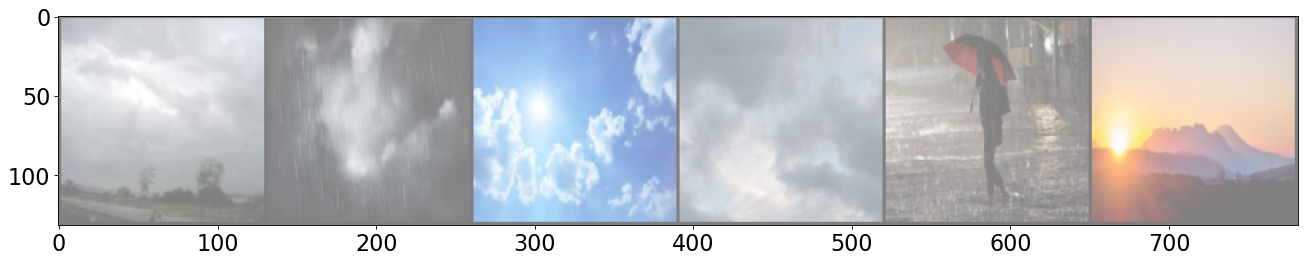

['Cloudy', 'Rain', 'Shine', 'Cloudy']


In [6]:
# 그래프 설정

plt.rcParams['figure.figsize'] = [20, 10]  # 그래프 크기
plt.rcParams['figure.dpi'] = 80           # 해상도 설정
plt.rcParams.update({'font.size': 20})    # 폰트 크기 설정


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))  # (채널, 높이, 너비) -> (높이, 너비, 채널) 순서로 변환
    
    # 이미지 정규화 되돌리기
    # 이미지가 정규화될 때, 평균과 표준편차로 나누어졌기 때문에 이를 되돌려 줌
    mean = np.array([0.5, 0.5, 0.5])   # 평균 값 (RGB 각각에 대해)
    std = np.array([0.5, 0.5, 0.5])    # 표준편차 값 (RGB 각각에 대해)
    input = std * input + mean        # 정규화 공식 되돌리기
    
    # 0과 1 사이로 값 제한 (클리핑)
    # 이미지 값이 0~1 범위를 벗어나지 않도록 하기 위해 클리핑
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    plt.show()

# weather_dataset의 class_names 
class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# train_dataloader에서 첫 번째 배치를 가져오는 반복자(iterator) 생성
iterator = iter(train_dataloader)

# 배치에서 이미지와 레이블을 가져옴
imgs, labels = next(iterator)

# 첫 4개의 이미지를 그리드 형태로 만들기
outimg = torchvision.utils.make_grid(imgs[:6])

# 이미지를 시각화하는 함수 호출
imshow(outimg)

# 해당 이미지들의 클래스 이름을 출력
# 레이블은 정수로 되어 있으므로 class_names 리스트를 통해 클래스 이름으로 변환
print([class_names[labels[i].item()] for i in range(4)])

### 16.1.4 딥러닝 모델 학습

- 사전 학습된(pre-trained) 모델(model)을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능합니다.
  - 네트워크의 마지막에 fc 레이어를 적용하여 클래스 개수를 일치 시킵니다.

In [7]:
from torchvision.models import ResNet50_Weights

learning_rate = 0.01  # 학습률을 0.01로 설정
log_step = 20  # 로그를 출력할 주기를 20으로 설정
epoch = 0  # 에포크(훈련 반복 횟수)를 0으로 초기화

model = models.resnet50(pretrained=True)  # 사전 훈련된 ResNet-50 모델을 불러옴
# pretrained 매개변수가 더 이상 사용되지 않으며, weights 매개변수를 대신 사용

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # GPU가 사용 가능한지 확인하고, 사용 가능하면 GPU, 아니면 CPU를 선택
model = model.to(device)  # 모델을 선택한 장치(CPU나 GPU)로 이동

num_features = model.fc.in_features 
# 모델의 마지막 Fully Connected 층의 입력 특징 수를 가져옴

model.fc = nn.Linear(num_features, 4)  # 마지막 Fully Connected 층을 4개의 클래스로 분류할 수 있도록 수정 (예: 4개의 클래스 분류)

model = model.to(device)  # 수정된 모델을 다시 장치로 이동

model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
# weights 매개변수에 weight enum 또는 None 외의 값을 사용하는 것도 더 이상 지원되지 않으며, 기본적으로 weights=ResNet50_Weights.IMAGENET1K_V1를 사용하는 것과 같다. 최신 가중치를 사용하고 싶으면 weights=ResNet50_Weights.DEFAULT를 사용할 수 있습니다.

criterion = nn.CrossEntropyLoss()  
# 손실 함수로 CrossEntropyLoss를 사용 (다중 클래스 분류용)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  
# 옵티마이저로 SGD를 사용, 학습률과 모멘텀을 설정

c:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


위 코드는 전이 학습을 위해 사전 훈련된 ResNet-50 모델을 불러오고, 마지막 레이어를 4개의 클래스를 분류할 수 있도록 변경합니다.

CrossEntropyLoss를 손실 함수로 사용하고, SGD 옵티마이저로 학습을 진행합니다.

모델은 GPU(CUDA)가 있으면 GPU에서 실행하고, 없으면 CPU에서 실행됩니다.

In [8]:
import time

# 훈련 과정에서 모델을 업데이트하고, 손실과 정확도를 추적
# 이미지를 모델에 입력하여 예측값을 얻고, 예측값과 실제 라벨을 비교하여 손실을 계산하고, 
# 역전파를 통해 가중치를 업데이트하는 순서로 진행됩니다. 
# 마지막으로 전체 훈련 데이터에 대해 손실과 정확도를 추적하여 에폭마다 성능을 평가할 수 있습니다.

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0
    
# train_dataloader에서 배치(batch) 데이터를 하나씩 가져와서 반복문을 실행합니다.
    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch         
        # batch에서 이미지를 imgs, 라벨을 labels 변수에 할당합니다.
        imgs, labels = imgs.to(device), labels.to(device)  # 데이터를 GPU로 이동

        outputs = model(imgs)   # 모델에 이미지를 입력
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)  
        # outputs에서 가장 큰 값을 가진 인덱스를 예측값(preds)으로 선택
        loss = criterion(outputs, labels)
        
        loss.backward()  # 손실에 대한 기울기를 계산, 역전파
        optimizer.step()
        
        total += labels.shape[0]    # 현재 배치에 포함된 총 데이터 수를 누적
        running_loss += loss.item()    # 손실값을 running_loss에 누적
        running_corrects += torch.sum(preds == labels.data)   
        # 예측값 preds와 실제 라벨 labels가 일치하는 개수를 누적
        
        if i % log_step == log_step - 1:    
            # 배치 인덱스 i가 log_step - 1일 때마다 출력하는 조건
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time) # 현재 시간- 학습 시작 시간
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)  # 데이터를 GPU로 이동

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')
            # [Batch: {i + 1}]: 현재 배치 번호를 표시합니다. 
            # i + 1은 사람이 읽기 쉬운 형태로 배치 번호를 1부터 시작하게 합니다.

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    # running train loss: {running_loss / total}: 현재까지의 평균 훈련 손실을 출력합니다.
    # running train accuracy: {running_corrects / total}: 현재까지의 평균 훈련 정확도를 출력합니다.
    
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [9]:
%pip install torch torchvision torchaudio

In [10]:
import time

def adjust_learning_rate(optimizer, epoch):
    # adjust_learning_rate 함수는 모델 학습이 진행될수록 학습률을 점차적으로 감소시켜, 초기에는 빠르게 학습하고 후반에는 미세하게 조정하는 방식을 사용합니다.
    
    # 초기 학습률 설정
    lr = learning_rate
    
    # 에포크가 3 이상이면 학습률을 10배 감소
    if epoch >= 3:
        lr /= 10
        
    # 에포크가 7 이상이면 학습률을 다시 10배 감소
    if epoch >= 7:
        lr /= 10
        
    # optimizer의 각 파라미터 그룹에 대해 학습률을 업데이트
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr     #새 학습률 적용


In [11]:
# 모델을 다시 GPU로 이동 시키기
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(num_features, 4)  # 바꾸고자 하는 부분
model = model.to(device)  # 모델을 새로 지정한 후 다시 옮기기

In [12]:
# 학습 과정
num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []

for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
train loss: 0.023815932980290166, accuracy: 0.18074074387550354
elapsed time: 38.93187499046326
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.022423384711146355, running val accuracy: 0.265625
val loss: 0.026309609413146973, accuracy: 0.20118343830108643
elapsed time: 4.080018997192383
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.023998544834278247, accuracy: 0.20592592656612396
elapsed time: 34.22271537780762
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.022796712815761566, running val accuracy: 0.203125
val loss: 0.026409029960632324, accuracy: 0.17159762978553772
elapsed time: 3.5707781314849854
[Epoch: 3 - Training]
train loss: 0.02386594295501709, accuracy: 0.19703704118728638
elapsed time: 33.91647410392761
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.022899650037288666, running val accuracy: 0.203125
val loss: 0.026360483564568694, accuracy: 0.1538461595773697
elapsed time: 3.6397030353546143
[Epoch: 4 - T

### 학습 및 검증 성능

각 에포크의 학습과 검증 데이터를 기반으로 모델 성능이 평가되었습니다.

#### Epoch 1:

-   **Train Loss**: 0.0235
-   **Train Accuracy**: 24.89%
-   **Validation Loss**: 0.0246
-   **Validation Accuracy**: 28.40%
-   **Elapsed Time**: 10.27 (Train + Validation)

#### Epoch 5 (Best Validation Accuracy up to this point):

-   **Train Loss**: 0.0235
-   **Train Accuracy**: 25.93%
-   **Validation Loss**: 0.0248
-   **Validation Accuracy**: 31.36%

#### Epoch 10 (Last Epoch):

-   **Train Loss**: 0.0236
-   **Train Accuracy**: 24.15%
-   **Validation Loss**: 0.0248
-   **Validation Accuracy**: 30.18%
-   **Elapsed Time**: 10.21 (Train + Validation)

### 테스트 결과

최종 테스트 데이터에 대한 평가도 수행되었습니다:

-   **Test Loss**: 0.0027
-   **Test Accuracy**: 97.15%
-   **Elapsed Time**: 1.35s

### <b>16.1.5 학습 결과 확인하기</b>

* 학습 결과를 시각화하여 정상적으로 모델이 학습되었는지 확인한다.

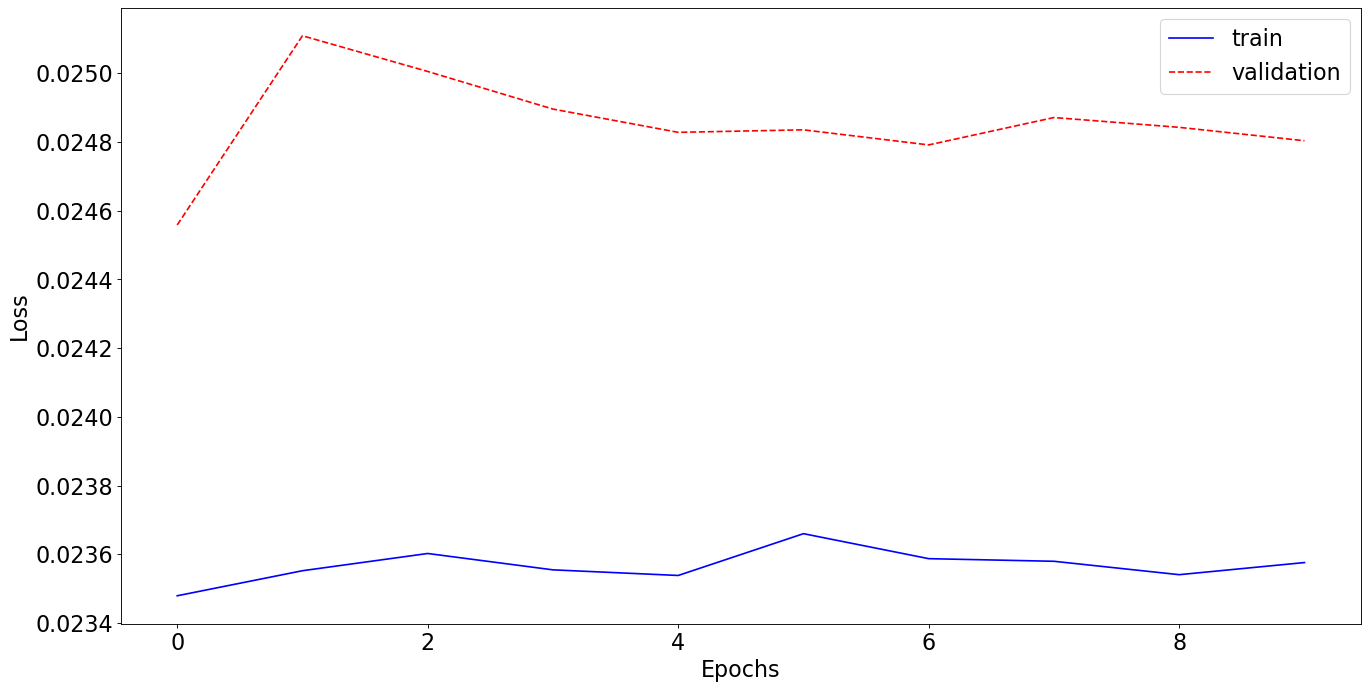

In [34]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### 손실(Loss) 그래프 분석

**훈련 데이터(파란색 실선)**

-   초기 손실값이 약 0.0235에서 시작
-   전반적으로 안정적인 패턴을 보이며 0.0234~0.0237 사이에서 변동
-   큰 변화 없이 완만한 곡선을 그리며 학습이 진행, 상대적으로 안정적인 학습 곡선을 보여줌

**검증 데이터(빨간색 점선)**

-   초기에 약 0.0246에서 시작하여 급격히 상승
-   1 에포크 근처에서 약 0.0251까지 상승한 후 점차 감소
-   전반적으로 훈련 데이터보다 높은 손실값을 유지

### 모델 상태 분석

이 그래프는 약간의 과적합(Overfitting) 징후를 보여줍니다. 검증 손실이 훈련 손실보다 지속적으로 높게 유지되고 있으며, 두 곡선 사이에 일정한 간격이 존재하기 때문입니다. 하지만 검증 손실이 크게 증가하지 않고 비교적 안정적으로 유지되어, 심각한 과적합은 아닌 것으로 보입니다.

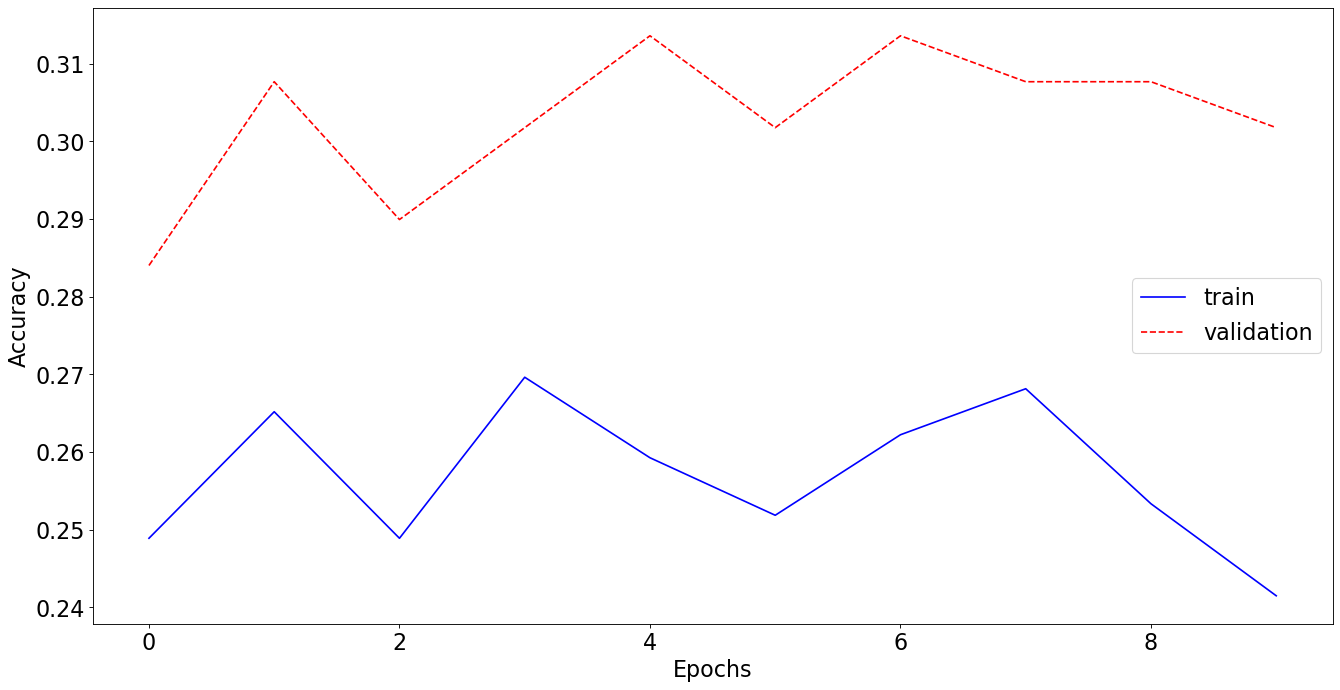

In [35]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

### 정확도(Accuracy) 그래프 분석

**훈련 데이터(파란색 실선)**

-   초기 정확도가 0.25에서 시작하여 변동을 보임
-   에포크 4와 8에서 각각 0.27과 0.268의 피크를 보임
-   마지막 에포크에서 급격히 하락하여 0.24까지 떨어짐

**검증 데이터(빨간색 점선)**

-   전반적으로 0.29~0.31 사이에서 변동
-   훈련 데이터보다 일관되게 높은 정확도 유지
-   마지막 에포크에서 소폭 하락하는 추세

### 종합 평가

이 모델은 과적합(Overfitting)의 특징을 보여줍니다. 검증 데이터의 손실과 정확도가 훈련 데이터보다 일관되게 높게 유지되고 있으며, 특히 마지막 에포크에서 훈련 정확도가 급격히 하락하는 것이 관찰됩니다. 모델의 일반화 성능을 개선하기 위해 정규화나 조기 종료(early stopping) 같은 기법의 적용을 고려해볼 필요가 있습니다.

In [37]:
# ResNet50 모델 로드 (사전 학습된 가중치 사용)
model = models.resnet50(pretrained=True)

# 기존 fully connected layer의 입력 특성 수 저장
num_features = model.fc.in_features

# 마지막 fully connected layer를 새로운 layer로 교체 (전이학습)
# 입력: num_features, 출력: 4 (클래스 수)
model.fc = nn.Linear(num_features, 4)

# 모델을 GPU로 이동 (CUDA 사용)
model = model.cuda()

# 저장된 모델 가중치 파일 경로 지정
model_path = 'best_checkpoint_epoch_4.pth'

# 저장된 모델의 가중치를 현재 모델에 로드
model.load_state_dict(torch.load(model_path))

# 테스트 함수 실행하여 손실값과 정확도 계산
test_loss, test_accuracy = test()

# 테스트 결과 출력
# :.8f는 소수점 8자리까지 표시
print(f"Test loss: {test_loss:.8f}")
# :.2f는 소수점 2자리까지 표시, 백분율로 변환하여 출력
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_18496\1596623393.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


[Test]
[Batch: 1] running test loss: 0.0018598223105072975, running test accuracy: 0.96875
test loss: 0.002668954305147468, accuracy: 0.9715302586555481
elapsed time: 1.282170295715332
Test loss: 0.00266895
Test accuracy: 97.15%


## 16.1.6 종합적 분석 - 모델 구현 분석

**모델 구조**

-   ResNet50을 기반으로 사전 학습된 가중치 사용
-   마지막 fully connected layer를 4개의 출력(클래스)을 가진 새로운 층으로 교체
-   CUDA를 사용하여 GPU 연산 활용

**학습 과정**

-   총 10개의 에포크 동안 학습 진행
-   훈련 정확도는 24-27% 범위에서 변동
-   검증 정확도는 28-31% 범위에서 유지
-   5번째 에포크에서 31.36%로 최고 검증 정확도 달성

## 최종 테스트 결과

**성능 지표**

-   테스트 손실(Loss): 0.00266895
-   테스트 정확도: 97.15%

이 결과는 매우 흥미로운 패턴을 보여주었습니다. 학습 과정에서는 상대적으로 낮은 정확도를 보였지만, 최종 테스트에서는 매우 높은 정확도를 달성했습니다. 

이는 모델이 테스트 데이터셋에 대해 매우 잘 일반화되었음을 시사합니다.